In [411]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from datetime import datetime, timedelta
import datetime
import pickle
import functools
import itertools
import os
import json
from tqdm import tqdm, tqdm_notebook

# import catboost

# from sklearn.model_selection import train_test_split
# from sklearn import model_selection
# from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, mean_squared_error

# from keras.models import Sequential, load_model
# from keras.layers import Dense, Activation, Dropout, normalization, BatchNormalization
# import keras

# Initializing
sns.set()

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'
%load_ext snakeviz
%matplotlib inline

tqdm.pandas()

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [412]:
pd.__version__

'0.24.0'

In [413]:
import time
class timer():
    '''Контекстный менеджер, возвращающий время, затраченное на выполнение куска кода'''
    
    def __init__(self, title='Code', precision=3):
        self.title = title
        self.start = time.time()
        self.precision = precision
        
    def current_time(self):
        return time.time() - self.start
    
    def __enter__(self):
        return
    
    def __exit__(self, *args):
        print('{} took {} seconds to run.'.format(self.title, round(self.current_time(), self.precision)))

In [414]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.nan):
            return None
        else:
            return super(NpEncoder, self).default(obj)

### Creating region indices

In [415]:
df = pd.read_csv('../data/declarations_raw.csv')

In [416]:
df.head(1)

document_type party  person_id                 person_name  \
0  Антикоррупционная декларация  КПРФ          8  Зюганов Геннадий Андреевич   

   year  office_id           office_name                         office_post  \
0  2009         14  Государственная Дума  Член комитета Государственной Думы   

   office_type_id                         office_type_name  office_region_id  \
0               7  Федеральный, без региональной структуры               NaN   

  office_region_name  income_personal  income_relatives  savings  \
0                NaN       2075542.33         102279.19      0.0   

   real_estate_amount  real_estate_squares  real_estate_price  \
0                   3                448.7       2.390986e+07   

   real_estate_share_price mode_real_estate_region  
0             2.390986e+07                     NaN

In [417]:
df_region = df[['office_region_name', 'office_type_name']].drop_duplicates()

In [418]:
df_region[df_region['office_region_name'].isna()]

office_region_name                         office_type_name
0                    NaN  Федеральный, без региональной структуры
438                  NaN   Федеральный, с региональной структурой
736                  NaN               Организация, без структуры
3160                 NaN               Федеральный, со структурой
5953                 NaN           Надрегиональный, без структуры
14131                NaN   Организация, c региональной структурой

In [419]:
df['id_place_str'] = np.where(
    df['office_region_name'].notna(), 
    df['office_region_name'], 
    df['office_type_name'].map(lambda x: x.split(', ')[0]))

In [420]:
with open('../service_info/region_names.txt', 'r') as f:
    names = {line.split(':')[0]: int(line.split(':')[1].replace('\n', '')) 
             for line in f.readlines()}

In [421]:
unknown_names = {
    'Федеральный': 200,
    'Организация': 201,
    'Надрегиональный': 202,
    'Ханты-Мансийский автономный округ — Югра': 86,
    'Республика Тува (Тыва)': 17,
    'Удмуртская республика': 18,
    'Чувашская республика - Чувашия': 21,
    'Карачаево-Черкесская республика': 9,
    'Республика Крым*': 82,
    'Севастополь*': 92
}

names.update(unknown_names)

In [422]:
df['id_place'] = df['id_place_str'].map(names)

### Adding ratings to people

In [423]:
person_ratings = pd.read_csv('../data/mutny_factors.csv')

In [424]:
person_ratings.head()

person_id                    person_name        income  real_estate_price  \
0        880  иванов владимир александрович  3.403756e+06       5.063574e+08   
1      14083      каракаев борис николаевич  7.392841e+06       1.669090e+10   
2      14110   федоров алексей владимирович  9.688387e+05       2.294834e+09   
3      13375        носов сергей николаевич  7.679112e+05       1.013789e+11   
4      44062   борисова елена александровна  4.468868e+06       2.515160e+12   

   yearly_incomes_in_real_estate  contracts_count  contracts_sum  min_year  \
0                     148.764321             17.0    12099925.48    2011.0   
1                    2257.711353              NaN            NaN       NaN   
2                    2368.644146             14.0    10600855.14    2017.0   
3                  132019.055664             20.0     5538036.87    2011.0   
4                  562818.256996            191.0    70359799.85    2010.0   

   max_year  entries_count                 region  region_avg_wage  \
0    2017.0            1.0  нижегородская область     28553.509091   
1       NaN            NaN      псковская область     22417.781818   
2    2018.0            2.0      псковская область     22417.781818   
3    2011.0            1.0        курская область     25559.763636   
4    2019.0            5.0                 москва     72126.081818   

   region_yearly_income  active_nko_count  liquidated_nko_count  \
0         342642.109091               6.0                   8.0   
1         269013.381818               1.0                   1.0   
2         269013.381818               1.0                   1.0   
3         306717.163636               3.0                   2.0   
4         865512.981818               1.0                   3.0   

   offshore_found  factor_real_estate_q76  factor_real_estate_q96  \
0            True                    True                   False   
1            True                    True                    True   
2           False                    True                    True   
3           False                    True                    True   
4            True                    True                    True   

   factor_contracts_q51  factor_liq_nko_q81  factor_active_nko_q50  \
0                  True                True                   True   
1                 False                True                   True   
2                  True                True                   True   
3                  True                True                   True   
4                  True                True                   True   

   yearly_region_incomes_in_real_estate  factor_region_wages_deviation  \
0                          1.477803e+03                            2.0   
1                          6.204487e+04                            2.0   
2                          8.530557e+03                            2.0   
3                          3.305290e+05                            2.0   
4                          2.905976e+06                            2.0   

   factor_offshore  affiliate_count  \
0                1             25.0   
1                1             43.0   
2                0             43.0   
3                0             42.0   
4                1              NaN   

                                       affiliate_ids  mutny_index  \
0  [881, 883, 886, 894, 896, 1371, 1373, 1375, 13...          7.0   
1  [14080, 14081, 14082, 14084, 14085, 14086, 140...          7.0   
2  [14080, 14081, 14082, 14083, 14084, 14085, 140...          7.0   
3  [13341, 541, 13342, 13344, 13345, 13346, 13347...          7.0   
4                                                NaN          8.0   

   avg_affiliate_mutny  mutny_corrected  
0             2.487658         8.243829  
1             2.130362         8.065181  
2             2.130362         8.065181  
3             2.091459         8.045729  
4             0.000000         8.000000

In [425]:
person_ratings['person_rating'] = person_ratings['mutny_corrected']

In [426]:
# person_ids = df.person_id.unique()
# person_ratings = pd.DataFrame((np.random.randn(len(person_ids)) * 1.5 + 5).round(2), index=person_ids, columns=['person_rating'])

In [427]:
person_ratings.head()

person_id                    person_name        income  real_estate_price  \
0        880  иванов владимир александрович  3.403756e+06       5.063574e+08   
1      14083      каракаев борис николаевич  7.392841e+06       1.669090e+10   
2      14110   федоров алексей владимирович  9.688387e+05       2.294834e+09   
3      13375        носов сергей николаевич  7.679112e+05       1.013789e+11   
4      44062   борисова елена александровна  4.468868e+06       2.515160e+12   

   yearly_incomes_in_real_estate  contracts_count  contracts_sum  min_year  \
0                     148.764321             17.0    12099925.48    2011.0   
1                    2257.711353              NaN            NaN       NaN   
2                    2368.644146             14.0    10600855.14    2017.0   
3                  132019.055664             20.0     5538036.87    2011.0   
4                  562818.256996            191.0    70359799.85    2010.0   

   max_year  entries_count                 region  region_avg_wage  \
0    2017.0            1.0  нижегородская область     28553.509091   
1       NaN            NaN      псковская область     22417.781818   
2    2018.0            2.0      псковская область     22417.781818   
3    2011.0            1.0        курская область     25559.763636   
4    2019.0            5.0                 москва     72126.081818   

   region_yearly_income  active_nko_count  liquidated_nko_count  \
0         342642.109091               6.0                   8.0   
1         269013.381818               1.0                   1.0   
2         269013.381818               1.0                   1.0   
3         306717.163636               3.0                   2.0   
4         865512.981818               1.0                   3.0   

   offshore_found  factor_real_estate_q76  factor_real_estate_q96  \
0            True                    True                   False   
1            True                    True                    True   
2           False                    True                    True   
3           False                    True                    True   
4            True                    True                    True   

   factor_contracts_q51  factor_liq_nko_q81  factor_active_nko_q50  \
0                  True                True                   True   
1                 False                True                   True   
2                  True                True                   True   
3                  True                True                   True   
4                  True                True                   True   

   yearly_region_incomes_in_real_estate  factor_region_wages_deviation  \
0                          1.477803e+03                            2.0   
1                          6.204487e+04                            2.0   
2                          8.530557e+03                            2.0   
3                          3.305290e+05                            2.0   
4                          2.905976e+06                            2.0   

   factor_offshore  affiliate_count  \
0                1             25.0   
1                1             43.0   
2                0             43.0   
3                0             42.0   
4                1              NaN   

                                       affiliate_ids  mutny_index  \
0  [881, 883, 886, 894, 896, 1371, 1373, 1375, 13...          7.0   
1  [14080, 14081, 14082, 14084, 14085, 14086, 140...          7.0   
2  [14080, 14081, 14082, 14083, 14084, 14085, 140...          7.0   
3  [13341, 541, 13342, 13344, 13345, 13346, 13347...          7.0   
4                                                NaN          8.0   

   avg_affiliate_mutny  mutny_corrected  person_rating  
0             2.487658         8.243829       8.243829  
1             2.130362         8.065181       8.065181  
2             2.130362         8.065181       8.065181  
3             2.091459         8.045729       8.045729  
4            

In [428]:
# df = df.merge(person_ratings, left_on='person_id', right_index=True, how='left')

### Each person info

In [429]:
df['party'] = df['party'].fillna('Беспартийный')

In [430]:
def get_file_for_person_id(person_id):
    return int(str(person_id).zfill(5)[:3])

In [431]:
officials_info_to_dump = {get_file_for_person_id(person_id): defaultdict(dict) 
                          for person_id in df.person_id.unique()}

In [432]:
def process_officials_info(df):
    info = dict()
    person_id = df.person_id.iloc[0]
    file_id = get_file_for_person_id(person_id)
    
#     info['rating'] = round(df.person_rating.mean(), 2)
#     info['risk_factors'] = ['Тест1: много воровал', 'Тест2: воровал больше других']
    
    # income info
    income_df = df.set_index('year').sort_index()
    info['personal_income'] = income_df.income_personal.to_dict()
    info['relatives_income'] = income_df.income_relatives.to_dict()
    info['savings'] = income_df.savings.to_dict()
    info['real_estate_amount'] = income_df.real_estate_amount.to_dict()
    info['real_estate_square_meters'] = income_df.real_estate_squares.to_dict()
    
    # other info
    info['year_start'] = df.year.min()
    info['year_end'] = df.year.max()
    info['last_position'] = df.sort_values('year').office_post.iloc[-1]
    info['journey_through_offices'] = df.groupby('office_post').year.unique().to_dict()
    
    # politics
    party = list(df.party.unique())
    info['political_parties'] = party
#     info['affiliates'] = ['id_aff1', 'id_aff2']
    
    officials_info_to_dump[file_id][str(person_id)].update(info)
#     return info

In [433]:
df_test = df[df.person_id == 8]

In [434]:
df_test.head()

document_type party  person_id                 person_name  \
0  Антикоррупционная декларация  КПРФ          8  Зюганов Геннадий Андреевич   
1  Антикоррупционная декларация  КПРФ          8  Зюганов Геннадий Андреевич   
2  Антикоррупционная декларация  КПРФ          8  Зюганов Геннадий Андреевич   
3  Антикоррупционная декларация  КПРФ          8  Зюганов Геннадий Андреевич   
4  Антикоррупционная декларация  КПРФ          8  Зюганов Геннадий Андреевич   

   year  office_id           office_name  \
0  2009         14  Государственная Дума   
1  2010         14  Государственная Дума   
2  2011         14  Государственная Дума   
3  2012         14  Государственная Дума   
4  2013         14  Государственная Дума   

                                         office_post  office_type_id  \
0                 Член комитета Государственной Думы               7   
1                 Член комитетa Государственной Думы               7   
2                                                NaN               7   
3  Член комитета ГД по науке и наукоемким техноло...               7   
4                 Член комитета Государственной Думы               7   

                          office_type_name  office_region_id  \
0  Федеральный, без региональной структуры               NaN   
1  Федеральный, без региональной структуры               NaN   
2  Федеральный, без региональной структуры               NaN   
3  Федеральный, без региональной структуры               NaN   
4  Федеральный, без региональной структуры               NaN   

  office_region_name  income_personal  income_relatives  savings  \
0                NaN       2075542.33         102279.19      0.0   
1                NaN       2127686.49         168601.94      0.0   
2                NaN       2177566.64         137656.24      0.0   
3                NaN       2458749.04         194266.38      0.0   
4                NaN       3194615.67         198267.22      0.0   

   real_estate_amount  real_estate_squares  real_estate_price  \
0                   3                448.7       2.390986e+07   
1                   3                448.7       4.094214e+07   
2                   3                448.7       4.384684e+07   
3                   3                448.7       2.390986e+07   
4                   3                448.7       2.390986e+07   

   real_estate_share_price mode_real_estate_region id_place_str  id_place  
0             2.390986e+07                     NaN  Федеральный       200  
1             4.094214e+07                  москва  Федеральный       200  
2             4.384684e+07                  москва  Федеральный       200  
3             2.390986e+07                     NaN  Федеральный       200  
4             2.390986e+07                     NaN  Федеральный       200

In [435]:
process_officials_info(df_test)

In [436]:
with timer():
    df.groupby('person_id').progress_apply(process_officials_info)


  6%|▌         | 3029/51673 [00:15<03:34, 226.56it/s]


 12%|█▏        | 6392/51673 [00:29<03:10, 237.59it/s]


 19%|█▉        | 9769/51673 [00:44<03:06, 224.50it/s]


 25%|██▌       | 12948/51673 [00:59<02:45, 233.41it/s]


 31%|███       | 15996/51673 [01:15<02:48, 211.48it/s]


 37%|███▋      | 19228/51673 [01:29<02:44, 196.85it/s]


 43%|████▎     | 22043/51673 [01:45<02:35, 189.94it/s]


 49%|████▊     | 25071/51673 [02:01<02:00, 220.47it/s]


 55%|█████▍    | 28301/51673 [02:16<01:52, 207.10it/s]


 61%|██████    | 31519/51673 [02:30<01:27, 230.93it/s]


 67%|██████▋   | 34794/51673 [02:45<01:26, 196.22it/s]


 73%|███████▎  | 37931/51673 [03:00<01:17, 176.73it/s]


 78%|███████▊  | 40563/51673 [03:16<01:08, 161.28it/s]


 84%|████████▎ | 43251/51673 [03:32<00:41, 205.10it/s]


 90%|████████▉ | 46352/51673 [03:47<00:22, 237.85it/s]


 96%|█████████▌| 49632/51673 [04:02<00:09, 210.67it/s]


100%|██████████| 51673/51673 [04:13<00:00, 217.92it/s]

Code took 253.1 seconds to run.


### Addings keys from ratings df

In [437]:
person_ratings.head()

person_id                    person_name        income  real_estate_price  \
0        880  иванов владимир александрович  3.403756e+06       5.063574e+08   
1      14083      каракаев борис николаевич  7.392841e+06       1.669090e+10   
2      14110   федоров алексей владимирович  9.688387e+05       2.294834e+09   
3      13375        носов сергей николаевич  7.679112e+05       1.013789e+11   
4      44062   борисова елена александровна  4.468868e+06       2.515160e+12   

   yearly_incomes_in_real_estate  contracts_count  contracts_sum  min_year  \
0                     148.764321             17.0    12099925.48    2011.0   
1                    2257.711353              NaN            NaN       NaN   
2                    2368.644146             14.0    10600855.14    2017.0   
3                  132019.055664             20.0     5538036.87    2011.0   
4                  562818.256996            191.0    70359799.85    2010.0   

   max_year  entries_count                 region  region_avg_wage  \
0    2017.0            1.0  нижегородская область     28553.509091   
1       NaN            NaN      псковская область     22417.781818   
2    2018.0            2.0      псковская область     22417.781818   
3    2011.0            1.0        курская область     25559.763636   
4    2019.0            5.0                 москва     72126.081818   

   region_yearly_income  active_nko_count  liquidated_nko_count  \
0         342642.109091               6.0                   8.0   
1         269013.381818               1.0                   1.0   
2         269013.381818               1.0                   1.0   
3         306717.163636               3.0                   2.0   
4         865512.981818               1.0                   3.0   

   offshore_found  factor_real_estate_q76  factor_real_estate_q96  \
0            True                    True                   False   
1            True                    True                    True   
2           False                    True                    True   
3           False                    True                    True   
4            True                    True                    True   

   factor_contracts_q51  factor_liq_nko_q81  factor_active_nko_q50  \
0                  True                True                   True   
1                 False                True                   True   
2                  True                True                   True   
3                  True                True                   True   
4                  True                True                   True   

   yearly_region_incomes_in_real_estate  factor_region_wages_deviation  \
0                          1.477803e+03                            2.0   
1                          6.204487e+04                            2.0   
2                          8.530557e+03                            2.0   
3                          3.305290e+05                            2.0   
4                          2.905976e+06                            2.0   

   factor_offshore  affiliate_count  \
0                1             25.0   
1                1             43.0   
2                0             43.0   
3                0             42.0   
4                1              NaN   

                                       affiliate_ids  mutny_index  \
0  [881, 883, 886, 894, 896, 1371, 1373, 1375, 13...          7.0   
1  [14080, 14081, 14082, 14084, 14085, 14086, 140...          7.0   
2  [14080, 14081, 14082, 14083, 14084, 14085, 140...          7.0   
3  [13341, 541, 13342, 13344, 13345, 13346, 13347...          7.0   
4                                                NaN          8.0   

   avg_affiliate_mutny  mutny_corrected  person_rating  
0             2.487658         8.243829       8.243829  
1             2.130362         8.065181       8.065181  
2             2.130362         8.065181       8.065181  
3             2.091459         8.045729       8.045729  
4            

In [438]:
for row in person_ratings.itertuples():
    person_id = row.person_id
    file_id = get_file_for_person_id(person_id)
    
    risk_factors = []
    
    if row.factor_offshore:
        risk_factors.append('Обнаружен в базе данных Offshore Leaks.')
        
    if row.factor_real_estate_q96:
        risk_factors.append(f'Отношение стоимости недвижимости к годовому доходу превышает 95 перцентиль. '
                            f'Стоимость недвижимости составляет доход за {round(row.yearly_incomes_in_real_estate)} лет.')
    elif row.factor_real_estate_q76:
        risk_factors.append(f'Отношение стоимости недвижимости к годовому доходу превышает 75 перцентиль.'
                            f'Стоимость недвижимости составляет доход за {round(row.yearly_incomes_in_real_estate)} лет.')
    
    if row.factor_contracts_q51:
        risk_factors.append(f'Участвовал в госзакупках: {round(row.entries_count)+1}. Это превышает медианное значение.')
        
    
    if row.factor_liq_nko_q81:
        risk_factors.append(f'Ликвидированных НКО: {round(row.liquidated_nko_count)}. Это превышает медианное значение.')
    
    
    if row.factor_active_nko_q50:
        risk_factors.append(f'Активных НКО: {round(row.active_nko_count)}.')
        
    if row.factor_region_wages_deviation:
        diff = row.yearly_region_incomes_in_real_estate - row.yearly_incomes_in_real_estate
        risk_factors.append(f'Большой разрыв доходов с доходами по региону. '
                            f'Стоимость недвижимости во владении составляет {round(row.real_estate_price)} руб. '
                            f'Среднему жителю региона ({row.region}) требуется {round(row.yearly_region_incomes_in_real_estate)} лет ' 
                            f'(на {round(diff)} лет дольше), чтобы столько заработать.')
        
    
    if row.avg_affiliate_mutny >= 2:
        risk_factors.append(f'Связанные лица имеют высокий индекс мутной воды: {round(row.avg_affiliate_mutny, 3)}.')
    
    affiliate_ids = row.affiliate_ids
    if isinstance(affiliate_ids, str):
        affiliate_ids = eval(affiliate_ids)
    if not affiliate_ids or affiliate_ids is np.NaN:
        affiliate_ids = []
    new_info = {
        'person_name': row.person_name,
        'rating': row.person_rating,
        'risk_factors': risk_factors,
        'affiliates': affiliate_ids
    }
    
#     print(new_info)
    officials_info_to_dump[file_id][str(person_id)].update(new_info)

In [439]:
officials_info_to_dump[200]['20033']

{'affiliates': [],
 'journey_through_offices': {'прокурор Республики': array([2015]),
  'прокурор Республики Тыва': array([2012, 2013, 2014])},
 'last_position': 'прокурор Республики',
 'person_name': 'гринев александр евгеньевич',
 'personal_income': {2012: 1069498.0,
  2013: 2124370.89,
  2014: 3961892.2,
  2015: 4220820.29},
 'political_parties': ['Беспартийный'],
 'rating': 0.08346432190590397,
 'real_estate_amount': {2012: 4, 2013: 5, 2014: 6, 2015: 7},
 'real_estate_square_meters': {2012: 263.0,
  2013: 282.8,
  2014: 343.6,
  2015: 389.2000000000001},
 'relatives_income': {2012: 567547.0,
  2013: 707707.15,
  2014: 370967.42,
  2015: 138137.29},
 'risk_factors': ['Большой разрыв доходов с доходами по региону. Стоимость недвижимости во владении составляет 16840774 руб. Среднему жителю региона (республика тыва) требуется 47 лет (на 42 лет дольше), чтобы столько заработать.'],
 'savings': {2012: 0.0, 2013: 0.0, 2014: 0.0, 2015: 0.0},
 'year_end': 2015,
 'year_start': 2012}

In [440]:
for file_name in officials_info_to_dump:
    with open(f'../../static_info/officials/{file_name}.json', 'w') as f:
        json.dump(officials_info_to_dump[file_name], f, cls=NpEncoder, indent=2)

In [441]:
# with open('../../static_info/officials/1.json', 'r') as f:
#     a = json.load(f)

In [442]:
def min_max(arr):
    return 10*(arr-arr.min())/(arr.max()-arr.min())

### Offices

In [443]:
ratings_df = person_ratings[['person_id', 'person_rating']]
ratings_df.shape

(53786, 2)

In [444]:
df.shape

(89556, 22)

In [445]:
merged_df = pd.merge(df, ratings_df, on='person_id', how='inner').drop_duplicates()
merged_df.shape

(89553, 23)

In [446]:
df = merged_df

In [447]:
df_offices = df.drop_duplicates(['person_id', 'office_id'])

In [448]:
df_offices.head()

document_type party  person_id  \
0   Антикоррупционная декларация  КПРФ          8   
8   Антикоррупционная декларация  КПРФ          9   
16  Антикоррупционная декларация  КПРФ         10   
23  Антикоррупционная декларация  КПРФ         11   
27  Антикоррупционная декларация  КПРФ         12   

                    person_name  year  office_id           office_name  \
0    Зюганов Геннадий Андреевич  2009         14  Государственная Дума   
8        Алферов Жорес Иванович  2009         14  Государственная Дума   
16   Андреев Андрей Анатольевич  2009         14  Государственная Дума   
23  Апарина Алевтина Викторовна  2009         14  Государственная Дума   
27     Афонин Юрий Вячеславович  2009         14  Государственная Дума   

                           office_post  office_type_id  \
0   Член комитета Государственной Думы               7   
8                                  NaN               7   
16                                 NaN               7   
23                                 NaN               7   
27                                 NaN               7   

                           office_type_name  office_region_id  \
0   Федеральный, без региональной структуры               NaN   
8   Федеральный, без региональной структуры               NaN   
16  Федеральный, без региональной структуры               NaN   
23  Федеральный, без региональной структуры               NaN   
27  Федеральный, без региональной структуры               NaN   

   office_region_name  income_personal  income_relatives  savings  \
0                 NaN       2075542.33         102279.19      0.0   
8                 NaN       7581193.00              0.00      0.0   
16                NaN       2077196.00         427300.37      0.0   
23                NaN       2248257.03              0.00      0.0   
27                NaN       1975954.00              0.00      0.0   

    real_estate_amount  real_estate_squares  real_estate_price  \
0                    3                448.7       2.390986e+07   
8                    6              12907.1       1.116196e+09   
16                   7                962.3       5.127804e+07   
23                   2                113.1       5.278161e+06   
27                   4               1957.1       9.155888e+07   

    real_estate_share_price mode_real_estate_region id_place_str  id_place  \
0              2.390986e+07                     NaN  Федеральный       200   
8              8.660303e+08         санкт-петербург  Федеральный       200   
16             5.127804e+07                     NaN  Федеральный       200   
23             5.278161e+06   волгоградская область  Федеральный       200   
27             8.990431e+07      московская область  Федеральный       200   

    person_rating  
0        1.861381  
8        2.766062  
16       2.967649  
23       0.814644  
27       1.276950

In [449]:
for office_id in tqdm(df_offices.office_id.unique()):
    df_office = df_offices[df_offices.office_id == office_id]
    office_json_to_dump = {
        row['person_id']: {
            'name': row['person_name'],
            'rating': row['person_rating']
        } for _, row in df_office.iterrows()
    }
    with open(f'../../static_info/offices/{office_id}.json', 'w') as f:
        json.dump(office_json_to_dump, f, indent=2)


100%|██████████| 2104/2104 [00:09<00:00, 231.35it/s]

### Regions

In [450]:
df_regions_ratings = df_offices.groupby(['id_place', 'office_id'], as_index=False).person_rating.agg('mean')
df_regions_ratings['person_rating'] = min_max(df_regions_ratings['person_rating'])

In [451]:
df_regions_ratings.head()

id_place  office_id  person_rating
0         1         12       4.743687
1         1        114       4.717461
2         1        115       1.103983
3         1        148       3.578108
4         1        362       0.641896

In [452]:
df_regions_ratings = df_regions_ratings.merge(
    df[['office_id', 'office_name']].drop_duplicates(), 
    how='left', left_on='office_id', right_on='office_id')

In [453]:
df_regions_ratings.head()

id_place  office_id  person_rating  \
0         1         12       4.743687   
1         1        114       4.717461   
2         1        115       1.103983   
3         1        148       3.578108   
4         1        362       0.641896   

                                      office_name  
0                         Глава республики Адыгея  
1  Государственный совет - Хасэ Республики Адыгея  
2                   Прокуратура Республики Адыгея  
3             Кабинет министров республики Адыгея  
4        Избирательная комиссия Республики Адыгея

In [454]:
for id_place in tqdm(df_regions_ratings.id_place.unique()):
    df_region = df_regions_ratings[df_regions_ratings.id_place == id_place]
    df_region['person_rating'] = min_max( df_region['person_rating'] ) 
    regions_ratings_to_dump = {
        row['office_id']: {
            'name': row['office_name'],
            'rating': row['person_rating']
        } for _, row in df_region.iterrows()
    }
    with open(f'../../static_info/regions/{id_place}.json', 'w') as f:
        json.dump(regions_ratings_to_dump, f, indent=2)


100%|██████████| 88/88 [00:14<00:00,  6.27it/s]

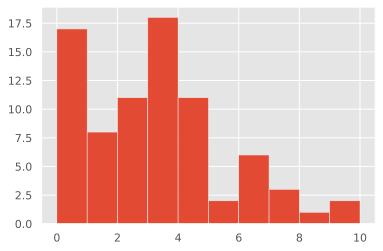

In [455]:
df_region['person_rating'].hist()

### Regions

In [456]:
df_regions = merged_df.drop_duplicates(['office_id', 'id_place']).drop(['person_rating'], axis=1)

In [457]:
df_regions.head()

document_type         party  person_id  \
0    Антикоррупционная декларация          КПРФ          8   
50   Антикоррупционная декларация          КПРФ         16   
141  Антикоррупционная декларация  Беспартийный         28   
147  Антикоррупционная декларация          КПРФ         29   
182  Антикоррупционная декларация  Беспартийный         34   

                    person_name  year  office_id  \
0    Зюганов Геннадий Андреевич  2009         14   
50       Данилова Нина Петровна  2011        267   
141  Левченко Сергей Георгиевич  2015        211   
147  Локоть Анатолий Евгеньевич  2012       1575   
182  Беляков Антон Владимирович  2013          5   

                                  office_name  \
0                        Государственная Дума   
50   Законодательное собрание Алтайского края   
141              Губернатор Иркутской области   
147             Новосибирск - городской округ   
182                           Совет Федерации   

                                           office_post  office_type_id  \
0                   Член комитета Государственной Думы               7   
50                                             депутат              18   
141                       Губернатор Иркутской области              18   
147                 член комитетa Государственной Думы              20   
182  Член Совета Федерации Федерального Собрания Ро...               7   

                            office_type_name  office_region_id  \
0    Федеральный, без региональной структуры               NaN   
50               Региональный, без структуры              24.0   
141              Региональный, без структуры              45.0   
147             Муниципальный, без структуры              68.0   
182  Федеральный, без региональной структуры               NaN   

        office_region_name  income_personal  income_relatives  savings  \
0                      NaN       2075542.33         102279.19      0.0   
50          Алтайский край       1055113.00          72213.00      0.0   
141      Иркутская область       4421294.28        1982145.93      0.0   
147  Новосибирская область       1999938.99         856925.39      0.0   
182                    NaN       2492121.00              0.00      0.0   

     real_estate_amount  real_estate_squares  real_estate_price  \
0                     3                448.7       2.390986e+07   
50                    4                910.5       4.140745e+07   
141                   7               1251.3       6.202106e+07   
147                   4                307.8       1.494481e+07   
182                   1                 70.8       3.772717e+06   

     real_estate_share_price mode_real_estate_region           id_place_str  \
0               2.390986e+07                     NaN            Федеральный   
50              3.815108e+07                     NaN         Алтайский край   
141             5.904384e+07                     NaN      Иркутская область   
147             1.494481e+07                     NaN  Новосибирская область   
182             3.772717e+06                     NaN            Федеральный   

     id_place  
0         200  
50         22  
141        38  
147        54  
182       200

In [458]:
df_regions_ratings.head()

id_place  office_id  person_rating  \
0         1         12       4.743687   
1         1        114       4.717461   
2         1        115       1.103983   
3         1        148       3.578108   
4         1        362       0.641896   

                                      office_name  
0                         Глава республики Адыгея  
1  Государственный совет - Хасэ Республики Адыгея  
2                   Прокуратура Республики Адыгея  
3             Кабинет министров республики Адыгея  
4        Избирательная комиссия Республики Адыгея

In [459]:
df_regions = df_regions.merge(
    df_regions_ratings[['office_id', 'person_rating']],
    how='left', left_on='office_id', right_on='office_id')

In [460]:
df_regions_ratings = df_regions.groupby(['id_place', 'id_place_str'], as_index=False).person_rating.agg('mean')

In [461]:
df_regions_ratings.head()

id_place             id_place_str  person_rating
0         1        Республика Адыгея       2.198957
1         2  Республика Башкортостан       2.270106
2         3       Республика Бурятия       1.223667
3         4         Республика Алтай       2.356425
4         5      Республика Дагестан       1.806295

In [462]:
df_regions_ratings['person_rating'] = min_max(df_regions_ratings['person_rating'])
df_regions_ratings.person_rating.describe()

count    88.000000
mean      4.966299
std       1.996033
min       0.000000
25%       3.655226
50%       5.036455
75%       6.048074
max      10.000000
Name: person_rating, dtype: float64

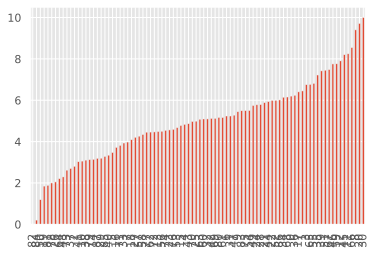

In [463]:
df_regions_ratings.person_rating.sort_values().plot(kind='bar')

In [464]:
regions_to_dump = {row['id_place']: {'name': row['id_place_str'], 'rating': row['person_rating']} 
                  for _, row in df_regions_ratings.iterrows()}

In [465]:
with open('../../static_info/regions.json', 'w') as f:
    json.dump(regions_to_dump, f)